In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [2]:
arrest_df = pd.read_csv('UsArrests.csv', index_col = 0)
arrest_df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [3]:
#The Urban Population is the only column in percentages and I would like to remember that.
d = {'UrbanPop': 'UrbanPop%'}
arrest_df.rename(columns=d, inplace=True)
arrest_df.head()

,Murder,Assault,UrbanPop%,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [4]:
arrest_df.shape

(50, 4)

In [5]:
arrest_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Murder     50 non-null     float64
 1   Assault    50 non-null     int64  
 2   UrbanPop%  50 non-null     int64  
 3   Rape       50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


There are only floats and integers, so I do not have to create boolean columns.

In [6]:
missing_values = arrest_df.isnull().sum()
missing_values

Murder       0
Assault      0
UrbanPop%    0
Rape         0
dtype: int64

There are no missing values, which means that we do not need to impute the data.

In [7]:
#Summarize the data
pd.set_option('display.float_format', lambda x: '%.2f' % x)

stat_properties = arrest_df.describe()
select = stat_properties.loc[["mean","std","min","max"]].transpose()
select

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop%,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


It seems as if assault is the crime that is the biggest issue in the population.

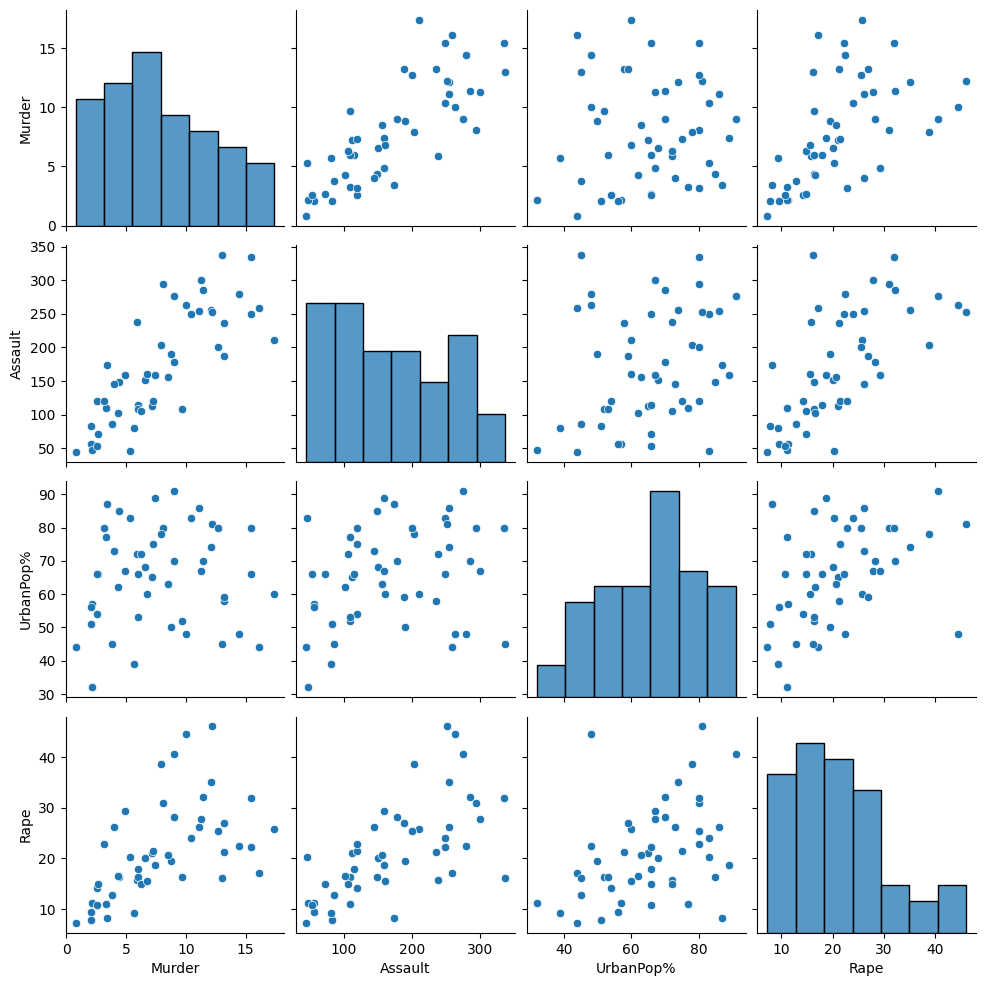

In [8]:
#Look at distribution of data in pairplots
sns.pairplot(data=arrest_df)

By simply looking at the data in the pairplots, we cannot see clear patterns and the data seems well distributed.

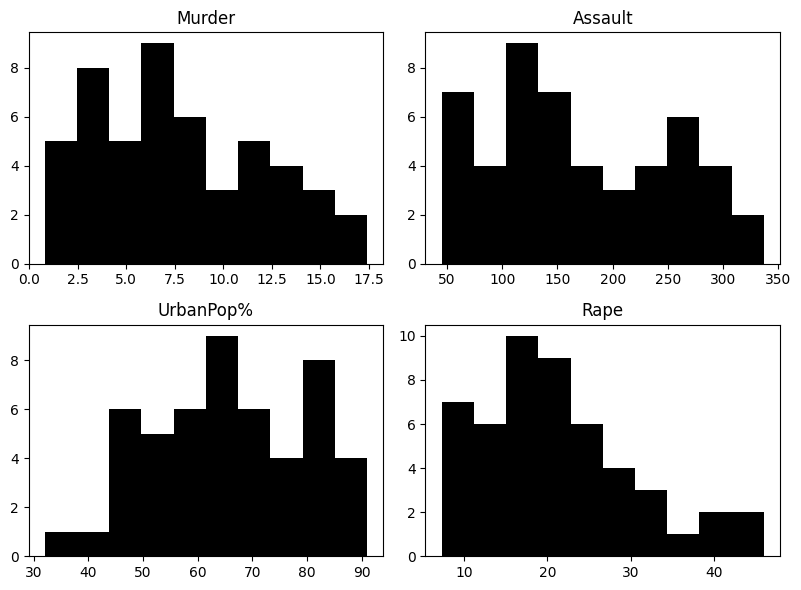

In [9]:
#Look at distribution with histograms
histograms = arrest_df.hist(color='black', grid=False, figsize=(8,6))
plt.tight_layout()
plt.show()

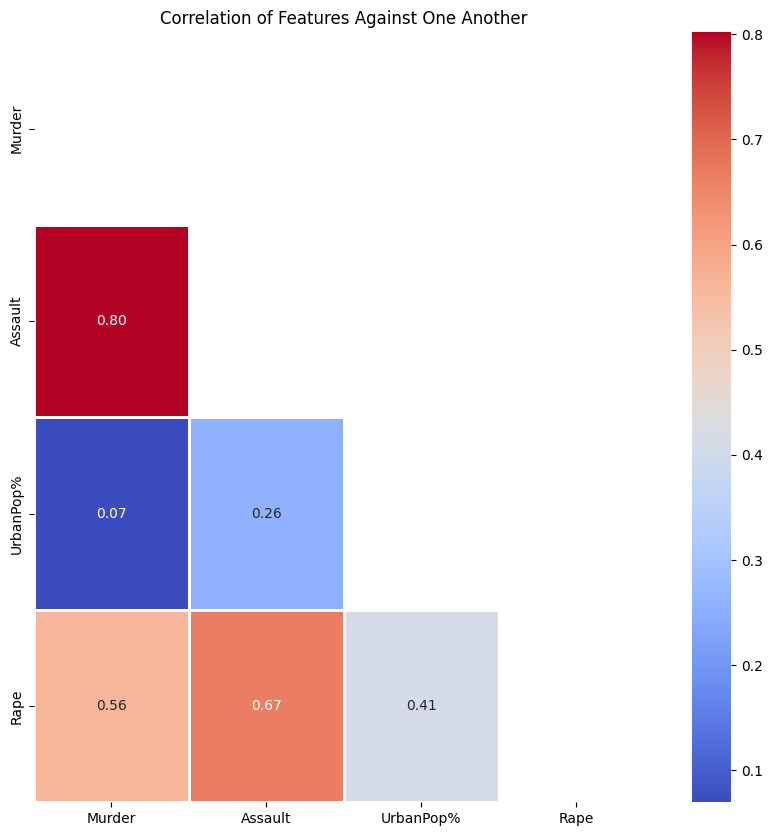

In [10]:
correlation = arrest_df.corr()

fig, ax = plt.subplots(figsize=(10,10))

cover = np.zeros_like(correlation)
cover[np.triu_indices_from(cover)] = True

ax = sns.heatmap(correlation, cmap='coolwarm', annot=True, fmt=".2f", mask=cover, linewidth=2)
plt.title("Correlation of Features Against One Another")
plt.show()

In the correlation graph above, we can see that all the features have a positive correlation towards one another, which means that as one feature increases, it is likely that the other features will increase as well.

The strongest correlation is between assult and murder at 0.8 where there is also a strong correlation between assult and rape at 0.67.  The urban population does not have a strong correlation to murder, assult or rape.  This shows us that the percentage of populations who live in urban areas does not automaticly have an impact on the amount of crime in that area.

The correlations between rape, assualt and muder are all positive and above 0.5 which indicates that if one of these crimes increases, the others will increase as well, especially between murder and assault.  Since there are high correlations in this data, it will do well for us to use Pricipal Component Analysis to see how we could decrease the variances.

In [11]:
#Create a new dataset with PCA
np.set_printoptions(precision=2) #Only two decimals

X = arrest_df.values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.80,11.45,-2.49,2.41
1,92.83,17.98,20.13,-4.09
2,124.07,-8.83,-1.69,-4.35
3,18.34,16.70,0.21,-0.52
4,107.42,-22.52,6.75,-2.81


In [12]:
feature_names = list(arrest_df.columns)

std = df_pca.describe().transpose()["std"]
std_dict = dict(zip(feature_names, std.values))
print("Standard Deviation:")
print(std_dict)

Standard Deviation:
{'Murder': 83.73240024640167, 'Assault': 14.212401849181358, 'UrbanPop%': 6.489426072877234, 'Rape': 2.482790000012727}


By looking at standard deviation, we can see the importance of each feature, because the higher the standard deviation is, the more variance is explained in data.  We can see that murder has the highest stadard deviation which means that the data points for murder are most spread out.  Rape has the lowest standard deviation which indicates that the data seldom moves away from the mean.

In [13]:
proportion = pca.explained_variance_ratio_
prop_dict = dict(zip(feature_names, proportion))
print(f"Proportion of Variance:")
print(prop_dict)

Proportion of Variance:
{'Murder': 0.9655342205668824, 'Assault': 0.02781733663217498, 'UrbanPop%': 0.00579953492234191, 'Rape': 0.0008489078786007117}


The proportion shows what the proportion out of 1 is for what the features attribute to variance in the data where we can now see that murder retains 96.55% of information of th original data where assualt retains 2.78%, the urban population 0.58% and rape 0.08%.

Because we have only 4 features, it is easy for us to see the importance of each feature in data clearly with the proportion and the standard deviation.

In [14]:
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
std_trans = std_pca.fit_transform(X_std)

df_std = pd.DataFrame(std_trans)
df_std.head()

,0,1,2,3
0,0.99,1.13,-0.44,0.16
1,1.95,1.07,2.04,-0.44
2,1.76,-0.75,0.05,-0.83
3,-0.14,1.12,0.11,-0.18
4,2.52,-1.54,0.60,-0.34


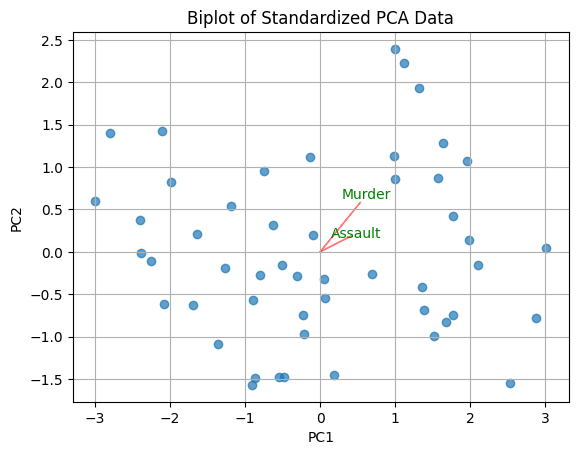

In [15]:
def biplot(score, coeff, labels=None):
    plt.scatter(score[:, 0], score[:, 1], alpha=0.7)
    for i in range(coeff.shape[1]):
        plt.arrow(0, 0, coeff[0, i], coeff[1, i], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[0, i] * 1.15, coeff[1, i] * 1.15, f"PC{i+1}", color='g', ha='center', va='center')
        else:
            plt.text(coeff[0, i] * 1.15, coeff[1, i] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()
    plt.title("Biplot of Standardized PCA Data")
    plt.show()
    
biplot(std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(feature_names))
plt.show()

So once again, we can see that murder and assualt are the two features with the most importance in the data to to the high standard deviation in these two, whereas the other two features (Rape and UrbanPop%) have data points that are close to the mean.

Text(0.5, 0, 'Number of Components')

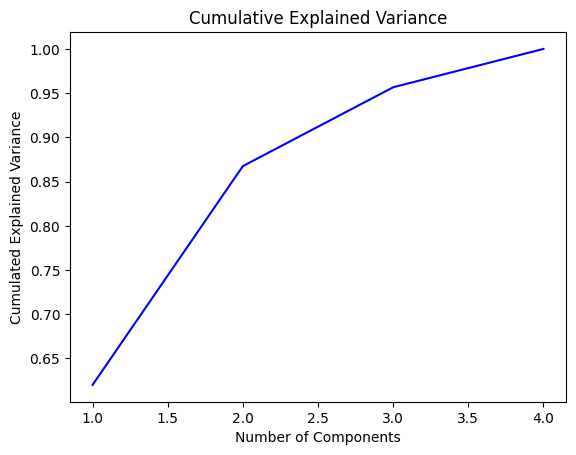

In [16]:
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='b')
plt.title("Cumulative Explained Variance")
plt.ylabel('Cumulated Explained Variance')
plt.xlabel('Number of Components')

In the Cumulative Explained Variance Graph we can see that three of the features explain 95% of the variance, those are the features which we need when working with clustering.  By looking at the proportions which we determined earlier, that will be murder, assualt and urbanpop%.

In [17]:
pca_df = pd.DataFrame(std_trans[:,0:3], index = arrest_df.index)
pca_df.head()

,0,1,2
City,,,
Alabama,0.99,1.13,-0.44
Alaska,1.95,1.07,2.04
Arizona,1.76,-0.75,0.05
Arkansas,-0.14,1.12,0.11
California,2.52,-1.54,0.60


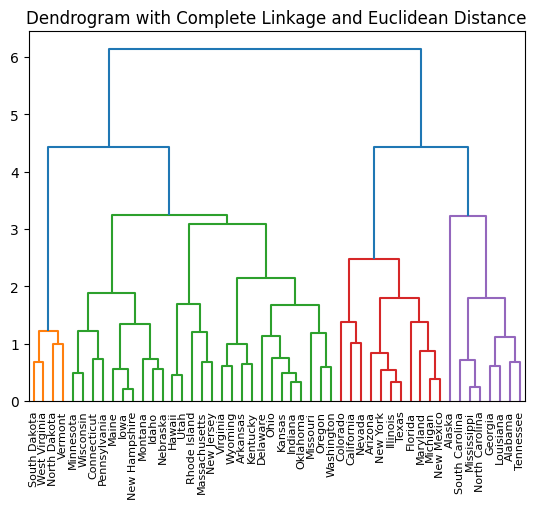

In [18]:
linkage1 = linkage(pca_df, method = 'complete', metric = 'euclidean')
plt.title("Dendrogram with Complete Linkage and Euclidean Distance")
dendrogram(linkage1, labels=pca_df.index, leaf_rotation=90)
plt.show()

I need to pick the amount of clusters we will be using going forward, so I will be looking at the silhoutte score of 4 and of 7.

In [19]:
clusters_num = 4
cluster = AgglomerativeClustering(n_clusters=clusters_num, affinity='euclidean', linkage='complete')
cluster = cluster.fit_predict(pca_df)

s_average = round((silhouette_score(pca_df, cluster)), 3)
print(f"The Silhoutte score is: {s_average}")

c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


The Silhoutte score is: 0.314


In [20]:
clusters_num = 7
cluster = AgglomerativeClustering(n_clusters=clusters_num, affinity='euclidean', linkage='complete')
cluster = cluster.fit_predict(pca_df)

s_average = round((silhouette_score(pca_df, cluster)), 3)
print(f"The Silhoutte score is: {s_average}")

The Silhoutte score is: 0.309


c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


By looking at this dendrogram and the silhoutte score, I will make k=4 because the silhoutte score is then 0.314, where it otherwise will be 0.309 with k=7.

c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


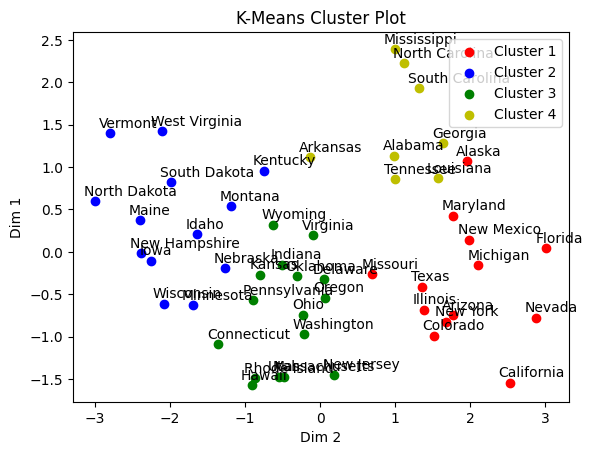

In [21]:
k=4
r = 43

x = std_trans[:,0]
y = std_trans[:,1]

kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i], label=f'Cluster {i+1}') 

for i, z in enumerate(arrest_df.index):
     ax.annotate(z, (x[i], y[i]), xytext=(-8, 4), textcoords='offset points')

ax.set_title("K-Means Cluster Plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


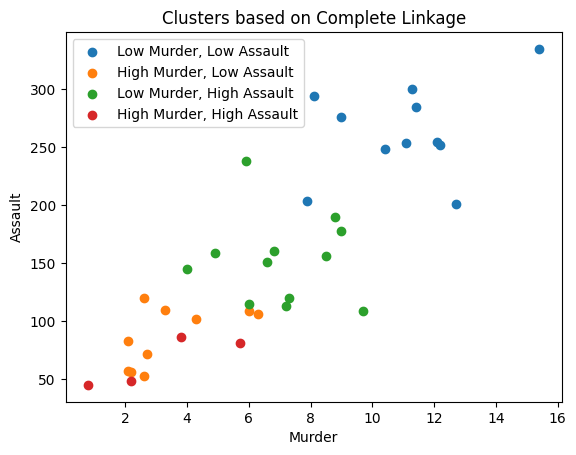

In [23]:
cluster = AgglomerativeClustering(n_clusters=clusters_num, affinity='euclidean', linkage='complete')
cluster_labels = cluster.fit_predict(pca_df)

cluster_names = {
    0: 'Low Murder, Low Assault',
    1: 'High Murder, Low Assault',
    2: 'Low Murder, High Assault',
    3: 'High Murder, High Assault'
}

arrest_df['Cluster'] = cluster_labels
arrest_df['Cluster Name'] = arrest_df['Cluster'].map(cluster_names)

unique_cluster_labels = np.unique(cluster_labels)

existing_cluster_labels = [label for label in unique_cluster_labels if label in cluster_names]

for x in existing_cluster_labels:
    cluster_data = arrest_df[arrest_df['Cluster'] == x]
    plt.scatter(cluster_data['Murder'], cluster_data['Assault'], label=cluster_names[x])

plt.title("Clusters based on Complete Linkage")
plt.xlabel("Murder")
plt.ylabel("Assault")
plt.legend()
plt.show()

In the cluster plot above, we can see that the cities are divided into four groups, the group with low murder and low assault (red group) have few cities and those cities can be considered safer.  

The high murder, low assault group is very close to the low murder, high assault group, which shows that those two clusters are similar to each other than to the others.  Cities in those two groups will be considered some of the more dangerous cities.